# Royalty Prediction per Artist using Multivariate Prophet
## Master's Thesis in Data Science
### Autor: Florencia Federico
This analysis applies a multivariate Facebook Prophet model, including exogenous variables such as social media followers and sentiment.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

file_git = 'https://raw.githubusercontent.com/florfede/royalty-forecasting-timeseries/refs/heads/main/data/dataset.csv'
df = pd.read_csv(file_git)
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.head()

,artist_id,date,royalties,instagram_followers,twitter_followers,track_release,sentiment,mentions_followers,num_posts,num_comments,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_mentions_followers_3m,month
0,436lvfnz,2022-07-01,94291.905,5250688,643908,1,0.649123,26326461,3,57,94291.90500,0.00000,0,0,1,0.649123,26326461,7
1,436lvfnz,2022-08-01,90967.300,5283706,647332,0,0.493088,26326461,7,217,92629.60250,23347.25170,3424,33018,1,0.571105,52652922,8
2,436lvfnz,2022-09-01,96849.325,5316966,648728,1,0.703297,0,5,91,94036.17667,33139.07363,1396,33260,2,0.615169,52652922,9
3,436lvfnz,2022-10-01,94944.180,5346661,649390,0,0.548611,50734,5,144,94263.17750,41478.03735,662,29695,2,0.581665,26377195,10
4,436lvfnz,2022-11-01,93308.900,5403544,649732,1,0.557554,26326461,10,278,94072.32200,58780.37927,342,56883,3,0.603154,26377195,11


In [4]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from tqdm.notebook import tqdm

resultados = []
predicciones = []

for artist_id, group in tqdm(df.groupby("artist_id")):
    group = group.sort_values("date")
    if len(group) < 10:
        continue

    # Renombrar columnas para Prophet
    df_prophet = pd.DataFrame({
        'ds': group['date'],
        'y': group['royalties'],
        'instagram_followers': group['instagram_followers'],
        'twitter_followers': group['twitter_followers'],
        'track_release': group['track_release'],
        'sentiment': group['sentiment'],
        'mentions_followers': group['mentions_followers'],
        'num_posts': group['num_posts'],
        'num_comments': group['num_comments'],
        'mean_royalties_6m': group['mean_royalties_6m'],
        'std_instagram_followers_6m': group['std_instagram_followers_6m'],
        'growth_twitter_followers': group['growth_twitter_followers'],
        'growth_instagram_followers': group['growth_instagram_followers'],
        'sum_track_releases_6m': group['sum_track_releases_6m'],
        'mean_sentiment_3m': group['mean_sentiment_3m'],
        'sum_mentions_followers_3m': group['sum_mentions_followers_3m'],
        'month': group['month']
    })

    train_size = int(len(df_prophet) * 0.8)
    train = df_prophet.iloc[:train_size]
    test = df_prophet.iloc[train_size:]

    try:
        model = Prophet()
        model.add_regressor('instagram_followers')
        model.add_regressor('twitter_followers')
        model.add_regressor('track_release')
        model.add_regressor('sentiment')
        model.add_regressor('mentions_followers')
        model.add_regressor('num_posts')
        model.add_regressor('num_comments')
        model.add_regressor('mean_royalties_6m')
        model.add_regressor('std_instagram_followers_6m')
        model.add_regressor('growth_twitter_followers')
        model.add_regressor('growth_instagram_followers')
        model.add_regressor('sum_track_releases_6m')
        model.add_regressor('mean_sentiment_3m')
        model.add_regressor('sum_mentions_followers_3m')
        model.add_regressor('month')

        model.fit(train)

        forecast = model.predict(test)

        mse = mean_squared_error(test['y'], forecast['yhat'])
        mae = mean_absolute_error(test['y'], forecast['yhat'])
        rmse = np.sqrt(mse)
        mape = mean_absolute_percentage_error(test['y'], forecast['yhat'])

        resultados.append({
            'Artist_ID': artist_id,
            'Model': 'Prophet',
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })

        for i in range(len(test)):
            predicciones.append({
                'artist_id': artist_id,
                'date': test.iloc[i]['ds'],
                'royalties_real': test.iloc[i]['y'],
                'royalties_pred': forecast.iloc[i]['yhat'],
                'model': 'Prophet'
            })

    except:
        continue

  0%|          | 0/15 [00:00<?, ?it/s]

19:35:07 - cmdstanpy - INFO - Chain [1] start processing
19:35:24 - cmdstanpy - INFO - Chain [1] done processing
19:35:25 - cmdstanpy - INFO - Chain [1] start processing
19:35:25 - cmdstanpy - INFO - Chain [1] done processing
19:35:26 - cmdstanpy - INFO - Chain [1] start processing
19:35:26 - cmdstanpy - INFO - Chain [1] done processing
19:35:26 - cmdstanpy - INFO - Chain [1] start processing
19:35:33 - cmdstanpy - INFO - Chain [1] done processing
19:35:33 - cmdstanpy - INFO - Chain [1] start processing
19:35:57 - cmdstanpy - INFO - Chain [1] done processing
19:35:58 - cmdstanpy - INFO - Chain [1] start processing
19:36:24 - cmdstanpy - INFO - Chain [1] done processing
19:36:24 - cmdstanpy - INFO - Chain [1] start processing
19:36:47 - cmdstanpy - INFO - Chain [1] done processing
19:36:48 - cmdstanpy - INFO - Chain [1] start processing
19:37:10 - cmdstanpy - INFO - Chain [1] done processing
19:37:10 - cmdstanpy - INFO - Chain [1] start processing
19:37:14 - cmdstanpy - INFO - Chain [1]

In [9]:
df_results = pd.DataFrame(resultados)
df_results.to_csv("prophet_metrics_per_artist.csv", index=False)

df_predicciones = pd.DataFrame(predicciones)
#df_predicciones.to_csv("prophet_predicciones_for_powerbi.csv", index=False)
df_results.head()

,Artist_ID,Model,MSE,MAE,RMSE,MAPE
0,436lvfnz,Prophet,2.329510e+10,1.272733e+05,1.526273e+05,0.783282
1,5jwhbt0o,Prophet,7.070968e+06,2.376569e+03,2.659129e+03,0.195634
2,5t4iv6o3,Prophet,1.461487e+10,1.132019e+05,1.208920e+05,0.339705
3,65m1vtnc,Prophet,2.194352e+12,1.237463e+06,1.481335e+06,1.813010
4,67gc5xm9,Prophet,5.365155e+10,1.956130e+05,2.316280e+05,0.516312


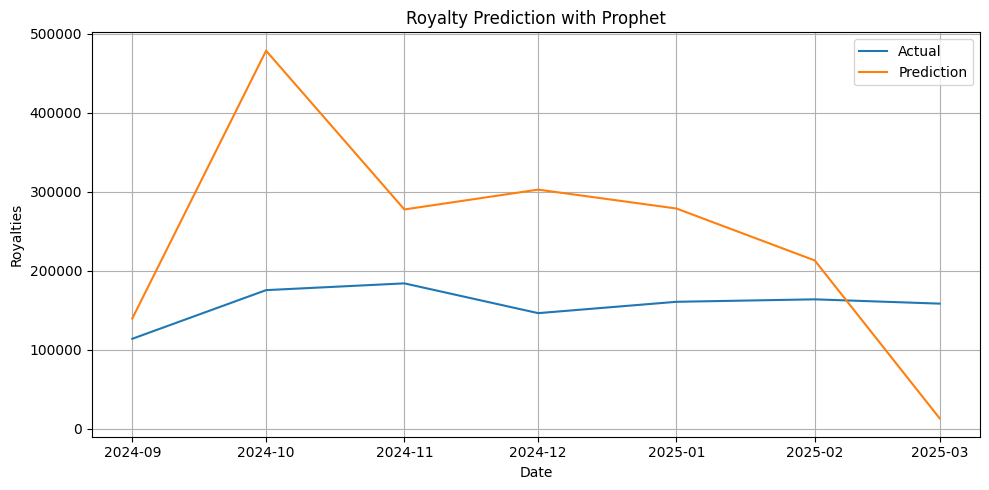

In [10]:
import matplotlib.pyplot as plt

example = df_predicciones[df_predicciones["artist_id"] == df_predicciones["artist_id"].unique()[0]]
plt.figure(figsize=(10,5))
plt.plot(example["date"], example["royalties_real"], label="Actual")
plt.plot(example["date"], example["royalties_pred"], label="Prediction")
plt.title("Royalty Prediction with Prophet")
plt.xlabel("Date")
plt.ylabel("Royalties")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Forecast

In [11]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

def forecast_prophet_por_artista(df, artist_id, steps=6):
    """
    Trains a Prophet model per artist and performs a forecast.

    Parameters:
    - df: DataFrame
    - artist_id: Artist ID
    - steps: Number of months to forecast

    Returns:
    - forecast_df: DataFrame with predictions
    - fig: Plot

    """
    # Filter artist
    df_artist = df[df['artist_id'] == artist_id].copy()
    df_artist = df_artist.sort_values('date')

    # Validate sufficient data
    if df_artist.empty or df_artist['royalties'].notna().sum() < 2:
        raise ValueError(f'Artist {artist_id} does not have enough data.')

    # Format for Prophet
    df_prophet = df_artist.rename(columns={'date': 'ds', 'royalties': 'y'})
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

    # Train model
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model.fit(df_prophet)

    # Create future dates
    future = model.make_future_dataframe(periods=steps, freq='MS')  # 'MS' = Month Start
    forecast = model.predict(future)

    # Take only future dates
    forecast_future = forecast[forecast['ds'] > df_prophet['ds'].max()].copy()

    # Prediction DataFrame
    forecast_df = pd.DataFrame({
        'artist_id': artist_id,
        'date_prediction': forecast_future['ds'],
        'royalties_forecast': forecast_future['yhat'],
        'lower_ci': forecast_future['yhat_lower'],
        'upper_ci': forecast_future['yhat_upper']
    })

    # Plot
    fig = model.plot(forecast)
    plt.title(f'Prophet Forecast - Artist {artist_id}')
    plt.xlabel('Date')
    plt.ylabel('Royalties')
    plt.tight_layout()
    plt.close(fig)

    return forecast_df, fig

# List of artists
artist_list = df['artist_id'].unique()

# Store results
forecast_list = []
figure_list = []

# Loop with try-except
for artist_id in artist_list:
    try:
        forecast_df, figure = forecast_prophet_por_artista(df, artist_id, steps=6)
        forecast_list.append(forecast_df)
        figure_list.append((artist_id, figure))
    except ValueError as e:
        print(f"Skipping artist {artist_id}: {e}")

# Consolidate all forecasts into a single DataFrame
consolidated_forecasts_df = pd.concat(forecast_list, ignore_index=True)


19:41:17 - cmdstanpy - INFO - Chain [1] start processing
19:41:17 - cmdstanpy - INFO - Chain [1] done processing
19:41:17 - cmdstanpy - INFO - Chain [1] start processing
19:41:17 - cmdstanpy - INFO - Chain [1] done processing
19:41:18 - cmdstanpy - INFO - Chain [1] start processing
19:41:18 - cmdstanpy - INFO - Chain [1] done processing
19:41:19 - cmdstanpy - INFO - Chain [1] start processing
19:41:19 - cmdstanpy - INFO - Chain [1] done processing
19:41:19 - cmdstanpy - INFO - Chain [1] start processing
19:41:20 - cmdstanpy - INFO - Chain [1] done processing
19:41:20 - cmdstanpy - INFO - Chain [1] start processing
19:41:20 - cmdstanpy - INFO - Chain [1] done processing
19:41:21 - cmdstanpy - INFO - Chain [1] start processing
19:41:21 - cmdstanpy - INFO - Chain [1] done processing
19:41:21 - cmdstanpy - INFO - Chain [1] start processing
19:41:22 - cmdstanpy - INFO - Chain [1] done processing
19:41:22 - cmdstanpy - INFO - Chain [1] start processing
19:41:22 - cmdstanpy - INFO - Chain [1]

Forecast chart for artist 436lvfnz


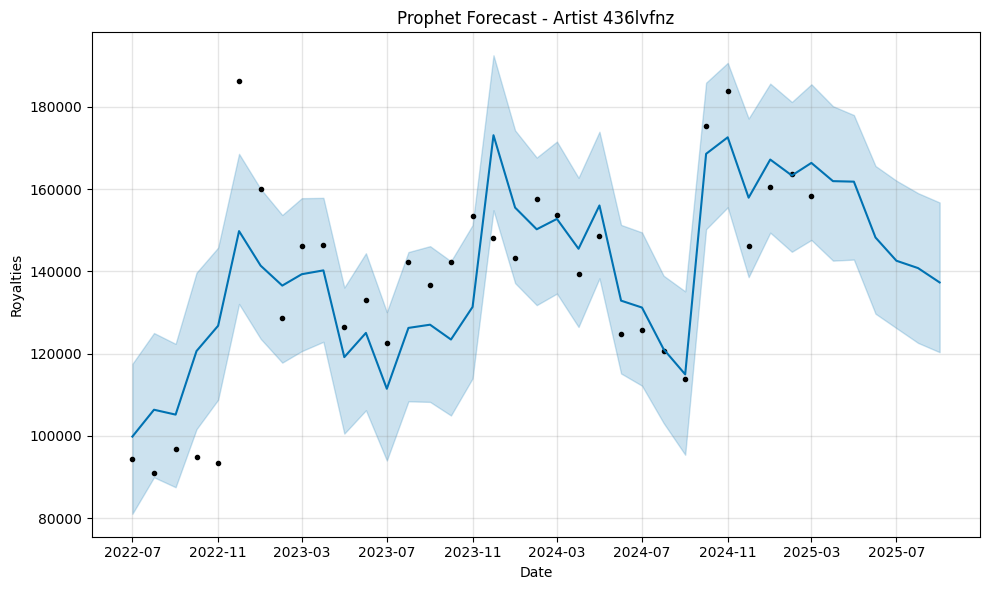

Forecast chart for artist 5jwhbt0o


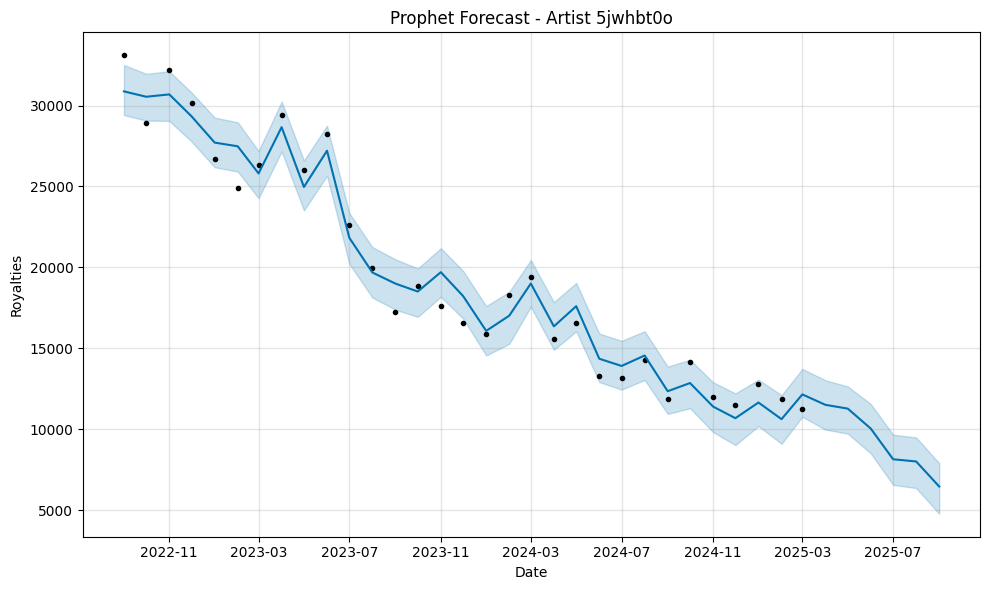

Forecast chart for artist 5t4iv6o3


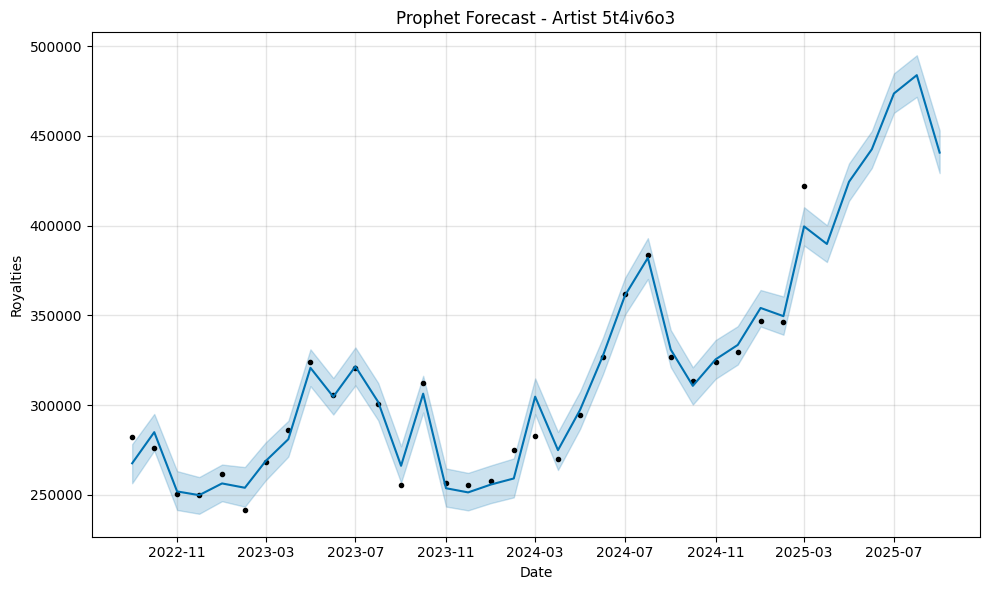

Forecast chart for artist 65m1vtnc


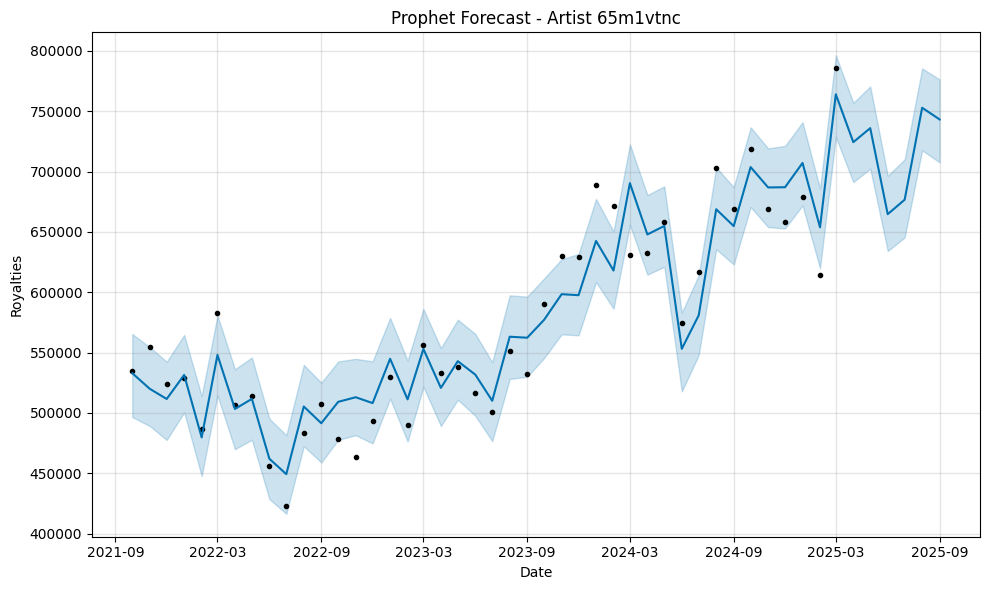

Forecast chart for artist 67gc5xm9


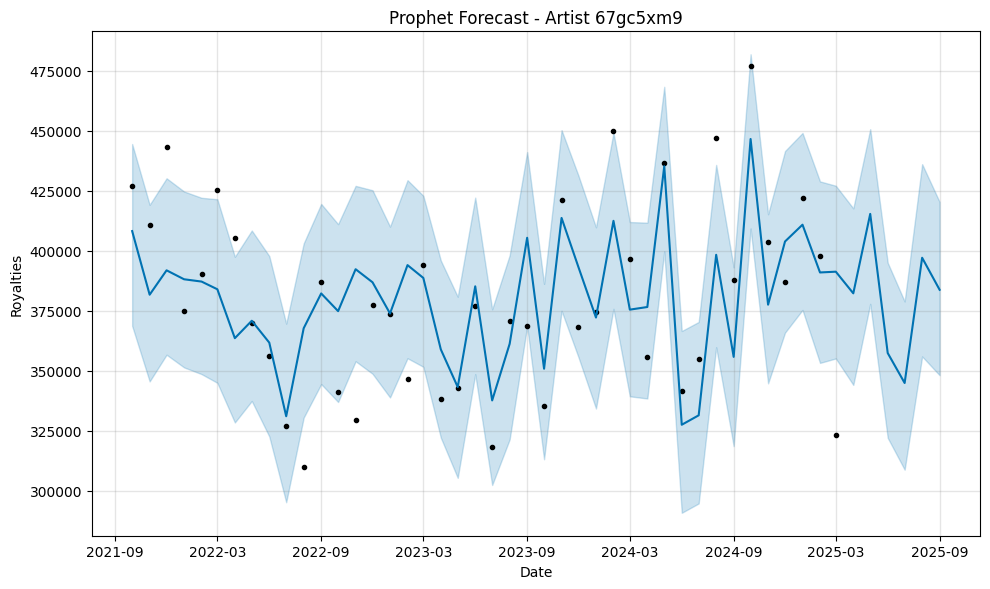

Forecast chart for artist 6ygz70qs


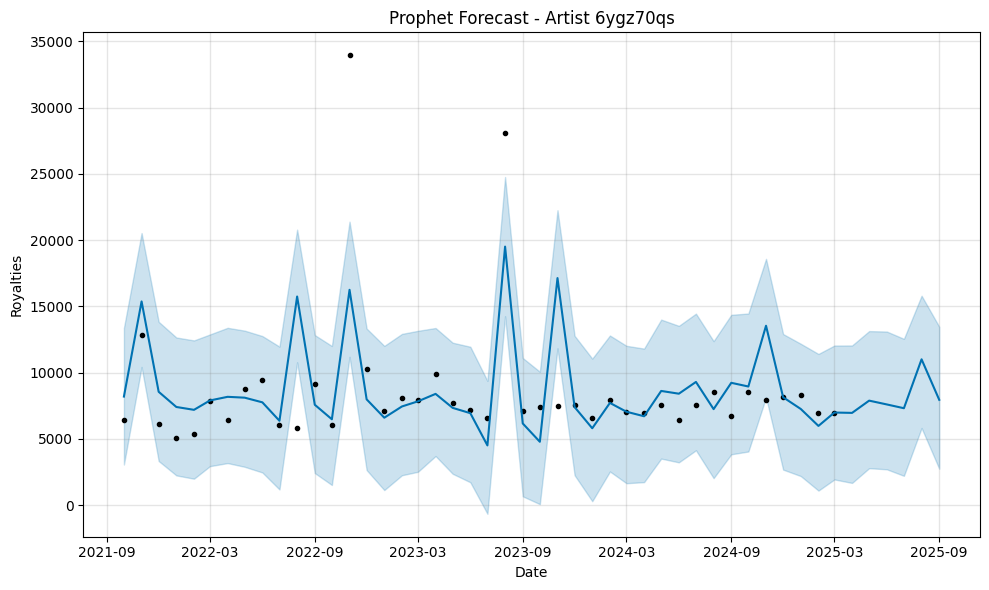

Forecast chart for artist al0gcvtm


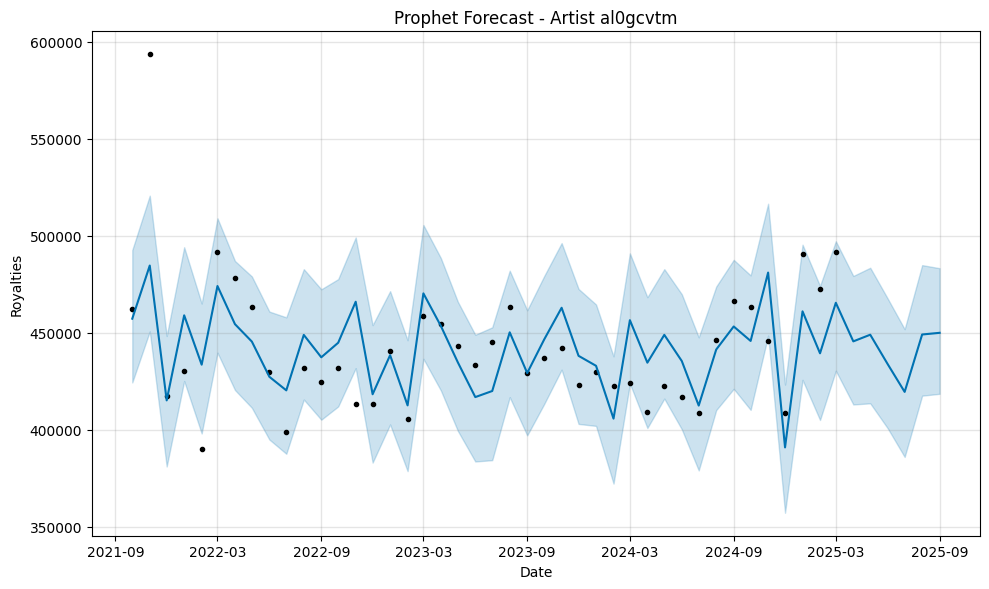

Forecast chart for artist awrkf92m


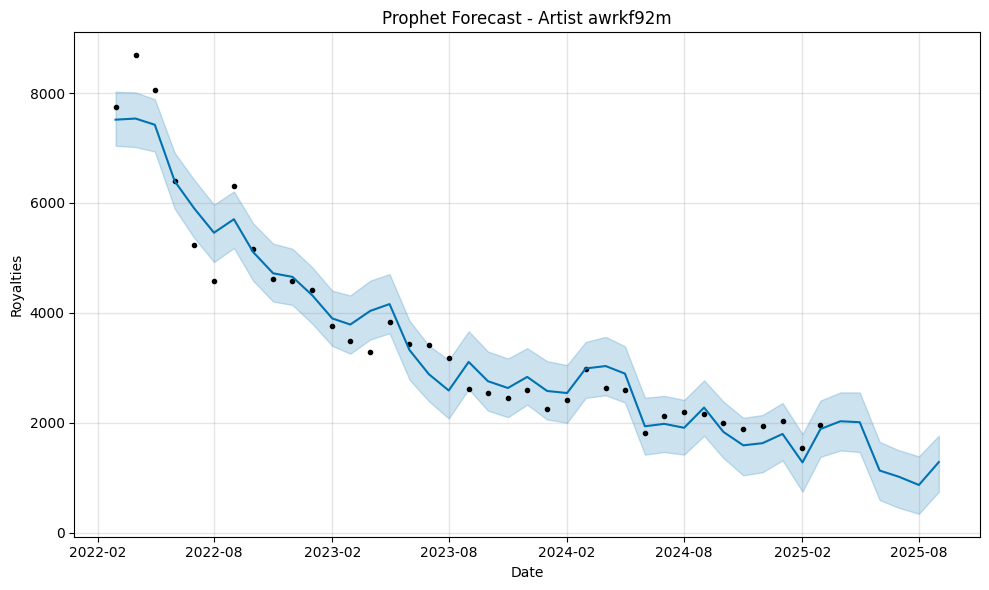

Forecast chart for artist bpgx7194


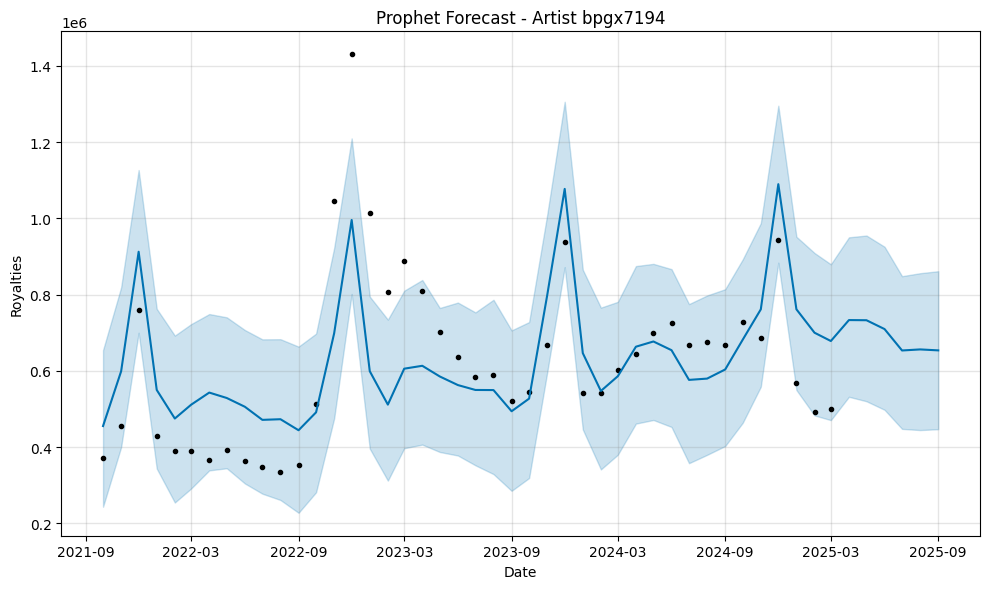

Forecast chart for artist hfiatnv8


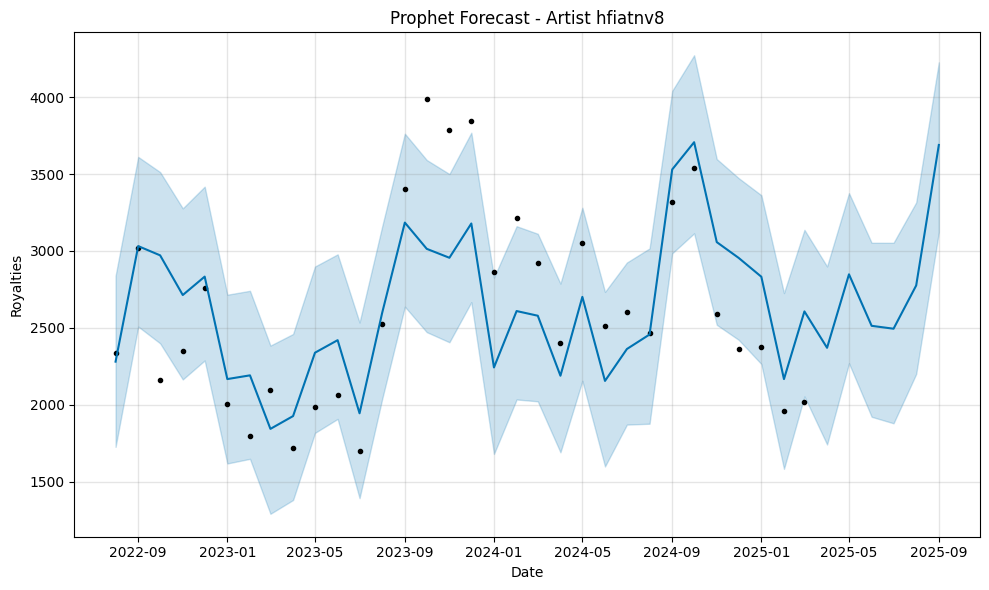

Forecast chart for artist jla6nu3p


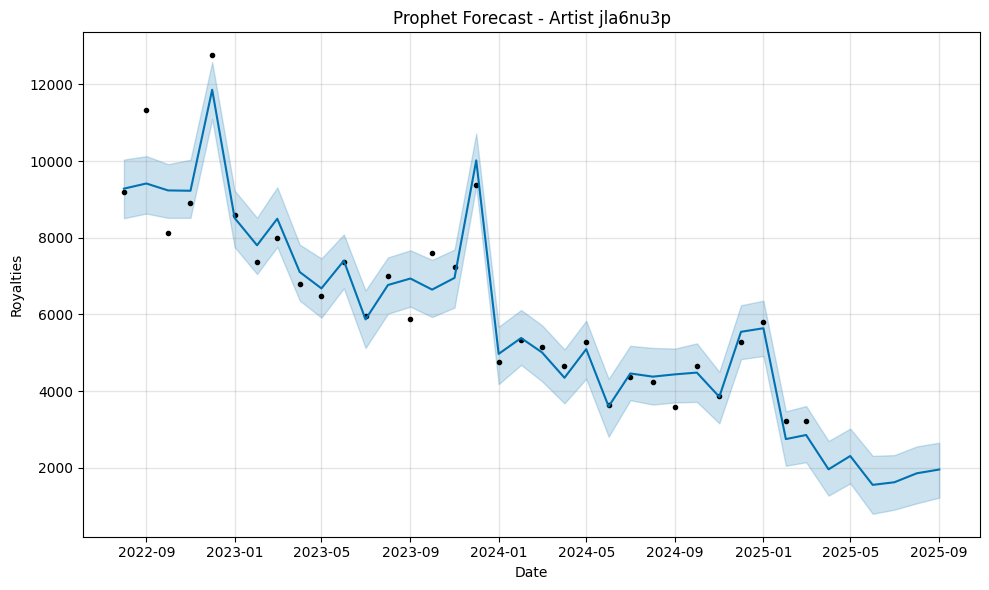

Forecast chart for artist k74pw1av


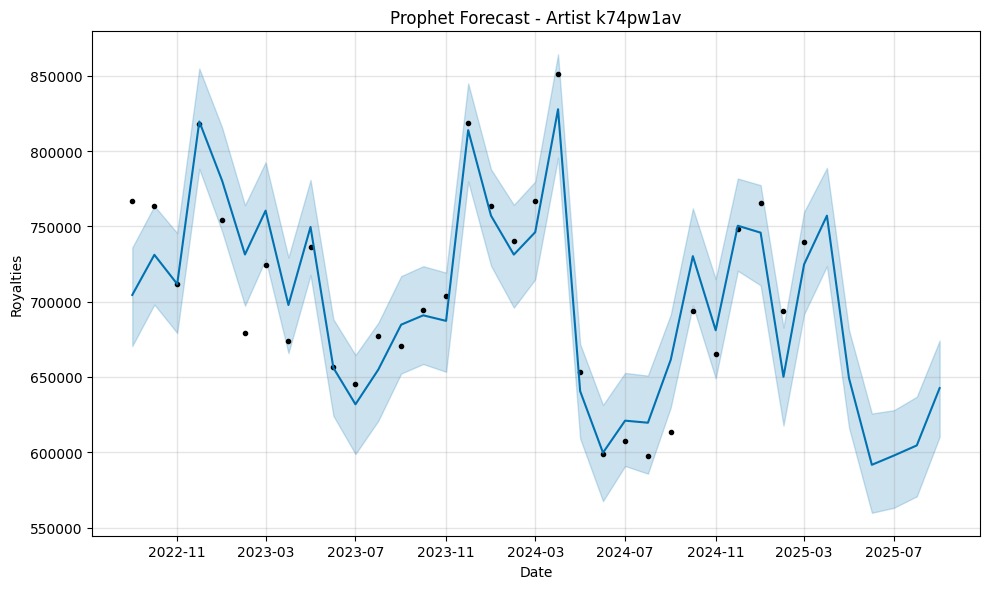

Forecast chart for artist kcw3uapo


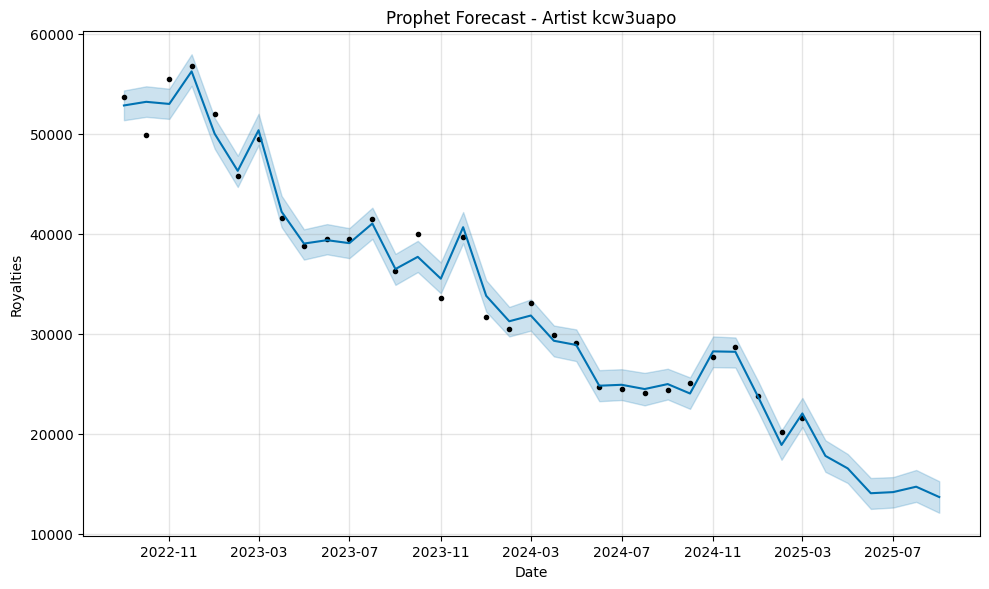

Forecast chart for artist pymr5w10


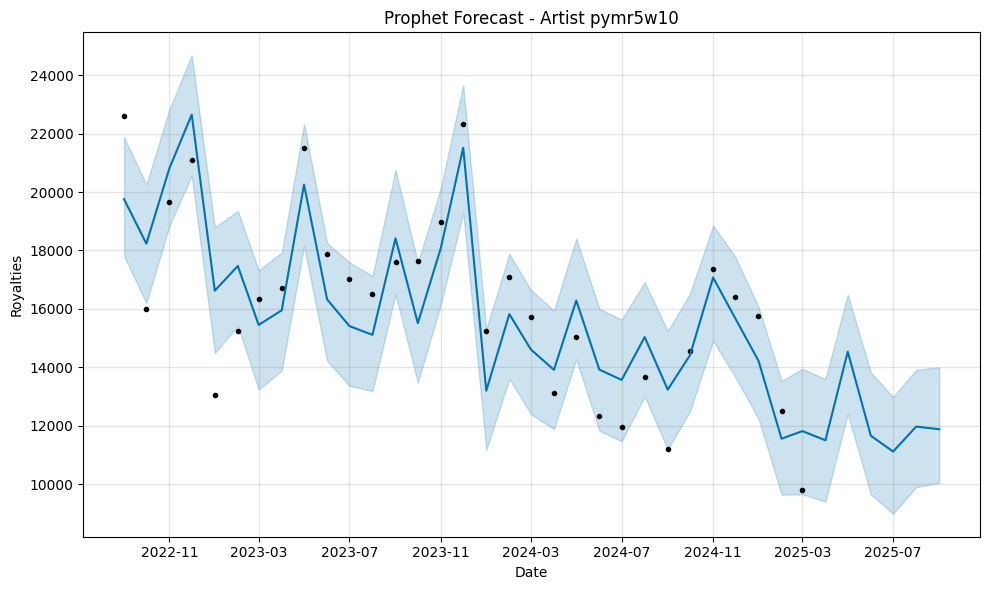

Forecast chart for artist r976ytqo


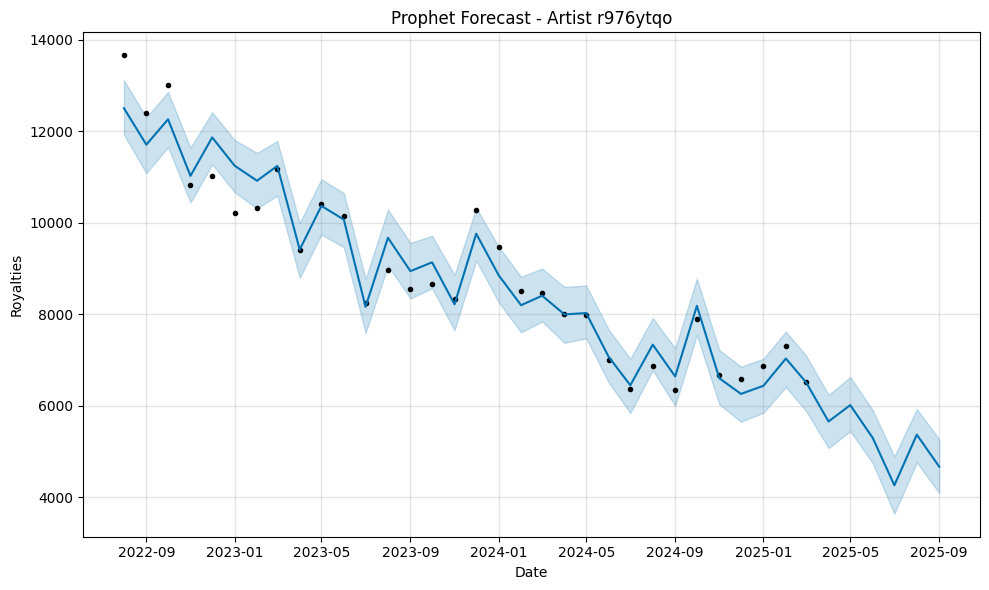

In [12]:
# Display charts
for artist_id, figure in figure_list:
    print(f"Forecast chart for artist {artist_id}")
    display(figure)
